In [2]:
#pip install xgboost

     |████████████████████████████████| 166.7MB 6.8MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [53]:
#pip install lightgbm

     |████████████████████████████████| 2.0MB 5.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
#Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder


import xgboost as xgb

In [2]:
df_train = pd.read_csv("train.csv", header = 0, delimiter = ",")
df_test = pd.read_csv("test.csv", header = 0, delimiter = ",")
sub_df = pd.read_csv("sample_submission.csv", header = 0, delimiter = ",")

In [3]:

df_test = sub_df.merge(df_test)

In [4]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (1460, 81)
Test set shape: (1459, 81)


#Feature Engineering


In [5]:
#Summing the areas to create a better feature 

df_train['TotalArea'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalArea'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [6]:
#drop old columns

for i in ['TotalBsmtSF', '1stFlrSF', "2ndFlrSF"]:
    df_train = df_train.drop(i, axis = 1)
    df_test = df_test.drop(i, axis = 1)

In [7]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (1460, 79)
Test set shape: (1459, 79)


In [8]:
co = (df_train.corr()**2)['SalePrice'].sort_values(ascending=False)[:15]
co

SalePrice       1.000000
OverallQual     0.625652
TotalArea       0.611931
GrLivArea       0.502149
GarageCars      0.410124
GarageArea      0.388667
FullBath        0.314344
TotRmsAbvGrd    0.284860
YearBuilt       0.273422
YearRemodAdd    0.257151
GarageYrBlt     0.236548
MasVnrArea      0.228000
Fireplaces      0.218023
BsmtFinSF1      0.149320
LotFrontage     0.123763
Name: SalePrice, dtype: float64

Looking at the features in the data set it is expected that OverallQual (Overall quality), Neighborhood, GrLivArea (Above grade (ground) living area square feet), and Total Area have a strong relationship with the SalePrice, So it is important to find any outliers if any are in dataset as these variables going to impact on our model.

#OverallQual 


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

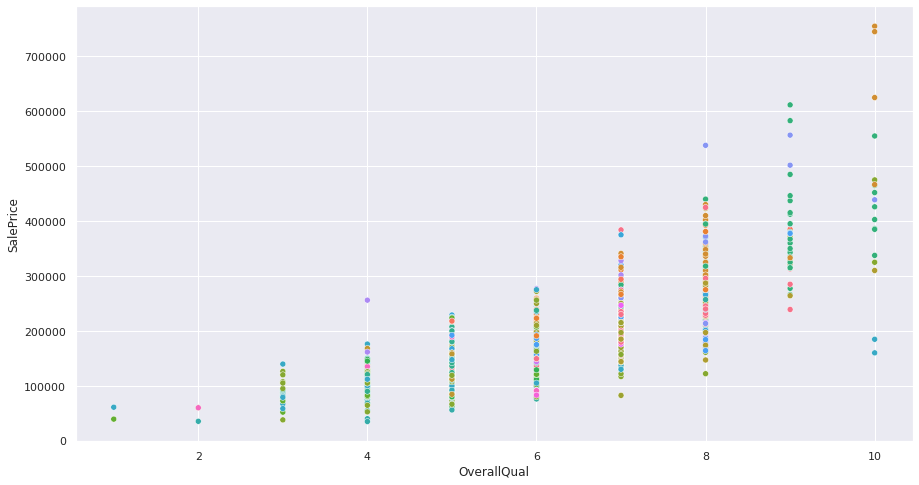

In [9]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['OverallQual'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

Looking at the plot the Overall seems fine. Also we can see which neighborhood are more expensive than others.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

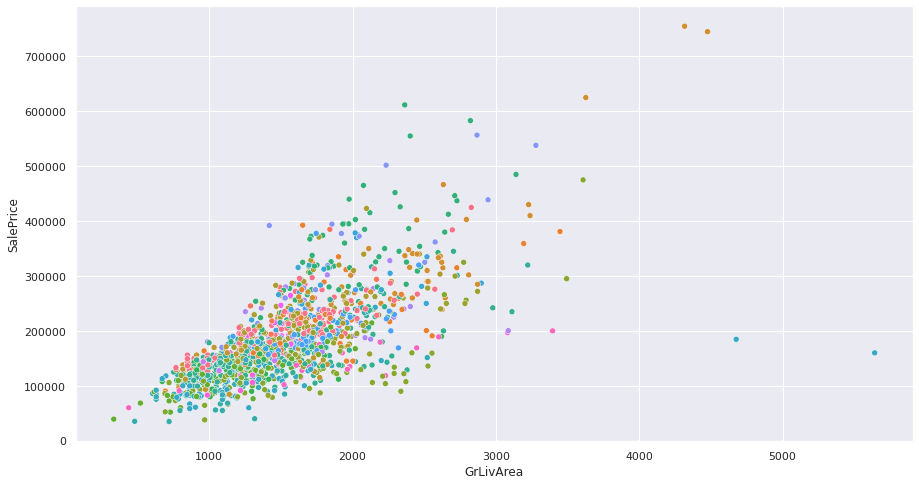

In [10]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

Overall the plot seems fine and can fit linearly, except for the two points which belongs to either Timber or Gilbert Neighborhood.

We can remove these outliers as it can impact our final results.

In [11]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

<AxesSubplot:xlabel='TotalArea', ylabel='SalePrice'>

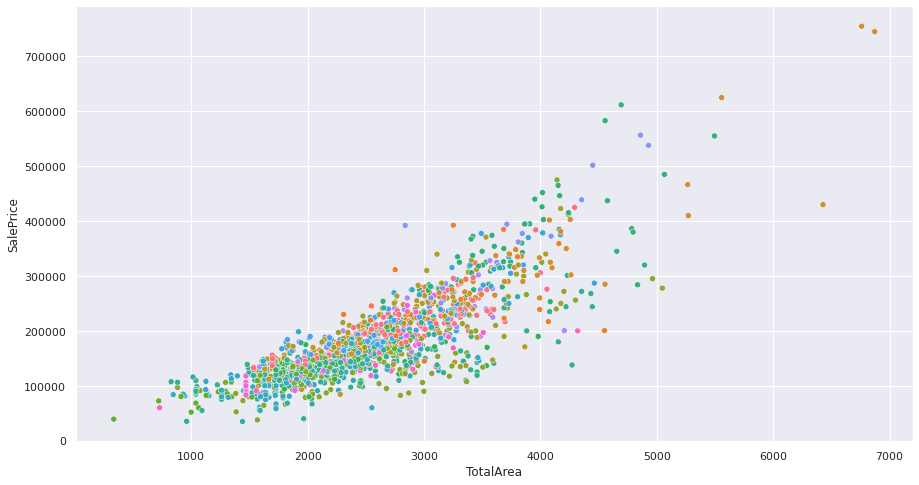

In [12]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['TotalArea'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

In [13]:
len_train = df_train.shape[0]
len_train

1458

In [14]:
# Joining the test and train datasets

df_concat = pd.concat([df_train, df_test], sort = False)


In [15]:

df_concat.shape

(2917, 79)

In [16]:
#Checking how the values are distributed 

df_concat.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalArea
count,2917.000000,2917.000000,2431.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2894.000000,2916.000000,...,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2916.000000
mean,1460.376071,57.135756,69.180584,10139.439150,6.086390,5.564964,1971.287967,1984.248200,101.733587,439.015432,...,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938,180058.118860,2543.086420
std,842.892456,42.532140,22.791719,7807.036512,1.406704,1.113414,30.286991,20.892257,178.510291,444.182329,...,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328,57399.973168,780.610132
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,334.000000
25%,731.000000,20.000000,59.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,154743.916061,2000.000000
50%,1461.000000,50.000000,68.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,...,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,176734.841494,2448.000000
75%,2190.000000,70.000000,80.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,191905.870132,2990.250000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,...,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,10190.000000


Skew: 2.55


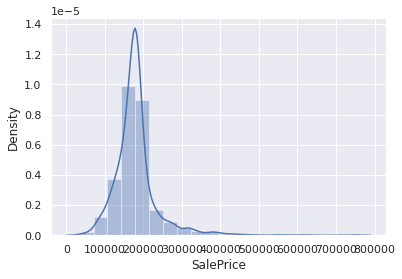

In [17]:
sns.distplot(df_concat['SalePrice'], bins = 20)
print("Skew:", round(df_concat['SalePrice'].skew(),2))

In this situation data is ***left SKEWED***, the mean and the median are both less than the mode. As a general rule, most of the time for data skewed to the left, the mean will be less than the median.


To normalize it we will take the log of SalePrice.

In [18]:
df_concat["SalePrice"] = np.log1p(df_concat["SalePrice"])

Skew: -0.15
Mean:  12.0580545118293
Median:  12.082411475848863
Mode:  0    11.849405
dtype: float64


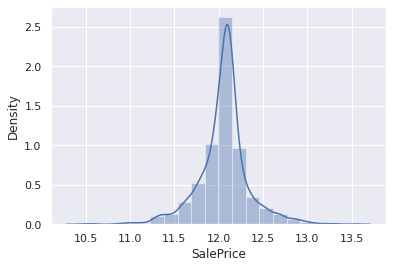

In [19]:
#Better fit 

sns.distplot(df_concat['SalePrice'], bins = 20)
print("Skew:", round(df_concat['SalePrice'].skew(),2))
print('Mean: ' ,np.mean(df_concat['SalePrice']))
print('Median: ', np.median(df_concat['SalePrice']))
print('Mode: ', df_concat['SalePrice'].mode())  

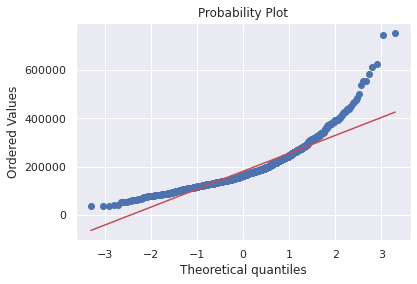

In [20]:
import scipy.stats as stats
import pylab

stats.probplot(df_train['SalePrice'], dist="norm", plot=pylab)
pylab.show()


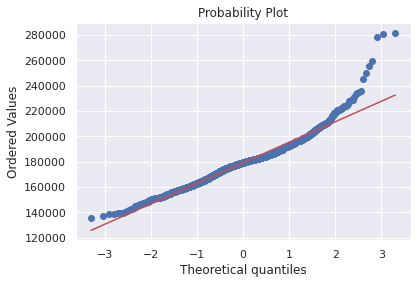

In [21]:
stats.probplot(df_test['SalePrice'], dist="norm", plot=pylab)
pylab.show()

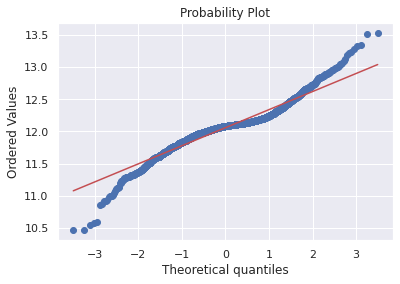

In [22]:
stats.probplot(df_concat['SalePrice'], dist="norm", plot=pylab)
pylab.show()

#Missing Value 

In [23]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2917 non-null   int64  
 1   MSSubClass     2917 non-null   int64  
 2   MSZoning       2913 non-null   object 
 3   LotFrontage    2431 non-null   float64
 4   LotArea        2917 non-null   int64  
 5   Street         2917 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2917 non-null   object 
 8   LandContour    2917 non-null   object 
 9   Utilities      2915 non-null   object 
 10  LotConfig      2917 non-null   object 
 11  LandSlope      2917 non-null   object 
 12  Neighborhood   2917 non-null   object 
 13  Condition1     2917 non-null   object 
 14  Condition2     2917 non-null   object 
 15  BldgType       2917 non-null   object 
 16  HouseStyle     2917 non-null   object 
 17  OverallQual    2917 non-null   int64  
 18  OverallC

We can see some of columns have few to a significant amount of missing data. 
Therefore, it is necessary to explore and figure out what to do fill data or drop columns/rows.





#**Seperating the categorical and non-categorical data.**

In [24]:
continuous = []
categorical = []

for i in df_concat.columns:
    if df_concat[i].dtype == "object":
        categorical.append(i)
    else: continuous.append(i)

print("Continuous:", continuous)
print("-")
print("Categorical:", categorical)

Continuous: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalArea']
-
Categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'Gar

In [25]:
isna_sum = df_concat[categorical].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
missing_categorical = pd.DataFrame(df_NaN_values.isna().sum(), columns = ["Missing values"])
missing_categorical.sort_values(["Missing values"], axis = 0, ascending = False)

,Missing values
PoolQC,2908
MiscFeature,2812
Alley,2719
Fence,2346
FireplaceQu,1420
GarageQual,159
GarageFinish,159
GarageCond,159
GarageType,157
BsmtCond,82


In [26]:
df_concat["Functional"].fillna("Typ", inplace = True)

In [27]:
for i in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', "MasVnrType", "MSSubClass", "FireplaceQu"]:
    
    df_concat[i].fillna("NA", inplace = True)

<h4> Categorical </h4>

In [28]:
isna_sum = df_concat[categorical].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
df_NaN_values.isna().sum()

MSZoning       4
Utilities      2
Exterior1st    1
Exterior2nd    1
Electrical     1
KitchenQual    1
SaleType       1
dtype: int64

In [29]:
for i in ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "SaleType"]:
    df_concat[i].fillna(df_concat[i].mode()[0], inplace = True)

<h4> Numerical </h4>

In [30]:

isna_sum = df_concat[continuous].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
missing_continuous = pd.DataFrame(df_NaN_values.isna().sum(), columns = ["Missing values"])
missing_continuous.sort_values(["Missing values"], axis = 0, ascending = False)

,Missing values
LotFrontage,486
GarageYrBlt,159
MasVnrArea,23
BsmtFullBath,2
BsmtHalfBath,2
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1
GarageCars,1
GarageArea,1


In [31]:
df_concat["LotFrontage"] = df_concat.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [32]:
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 
            'BsmtHalfBath', "MasVnrArea", "TotalArea"):
    
    df_concat[i].fillna(0, inplace = True)

In [33]:
#Check if all the values are filled or not 
def check():
  count = 0 
  for i in df_concat.columns:
    count += df_concat[i].isna().sum()
  if count == 0: 
    return "Filled"
  return "Nan Exists"
check()

'Filled'

Since there our plot showed in the begining that our data is left skewed. So, it needs to be modified and normalized 



If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. 
If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. 
If the skewness is less than -1 or greater than 1, the data are highly skewed.

In [34]:

big_skew = [feature for feature in continuous if abs(df_concat[feature].skew()) > 0.75]

In [35]:
print("High skewed data:", big_skew)
len(big_skew)

High skewed data: ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalArea']


20

In [36]:
len(continuous)
round(1 - 20/35,1)

0.4

APPLYING BOX COX TRANSFORMATION TO SKEWED DATA

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

The parameter lambda (0.15) minimizes the standard deviation of a standardized transformed variable.

In [37]:
for feature in big_skew:
    df_concat[feature] = boxcox1p(df_concat[feature], 0.15)


In [38]:
print("Skew:", round(df_concat['SalePrice'].skew(),2))

Skew: -0.15


It's is in the range -0.5 to 0.5(skew val) -> data is fairly symmetrical

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

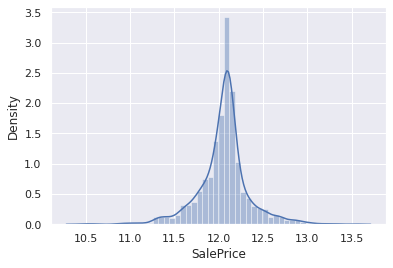

In [39]:
sns.distplot(df_concat['SalePrice'])

#GETTING DUMMIES FOR CATEGORICAL VALUES

In [40]:
df_concat = pd.get_dummies(df_concat)
print(df_concat.shape)

(2917, 302)


In [41]:
df_concat.shape

(2917, 302)

In [42]:
len_train

1458

#Splitting the DATA

In [43]:
train_set_final = df_concat.iloc[:len_train,:]
test_set_final = df_concat.iloc[len_train:,:]

In [44]:
print(train_set_final.shape)
print(test_set_final.shape)

(1458, 302)
(1459, 302)


In [45]:
X = train_set_final.drop('SalePrice',axis=1)
y = train_set_final[['SalePrice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [46]:
X_submission = test_set_final.drop('SalePrice',axis=1)

#Modelling

In [47]:
import lightgbm as lgb

In [67]:
modelsFinal = []

modelsFinal.append(('ENet', make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))))
modelsFinal.append(('Lasso', make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))))
modelsFinal.append(('RF',RandomForestRegressor()))
modelsFinal.append(('GB',GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)))
modelsFinal.append(("KRR",KernelRidge()))
modelsFinal.append(("Xgb",xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)))
modelsFinal.append(("LGB", lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)))


In [68]:
def compute_models(X, y):
    names = []
    scores = []
    frame = pd.DataFrame()
    
    for name, model in modelsFinal:
        model.fit(X, y)
        prediction = model.predict(X_submission)
        frame[name] = prediction
        scores.append(model.score(X_test,y_test))
        names.append(name)
    
    bla = pd.DataFrame(scores, index = names, columns = ["score"])
    print(bla)
    
    return frame

In [69]:
frame = compute_models(X_train, y_train)

[05:50:26] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
          score
ENet   0.914657
Lasso  0.914745
RF     0.87

In [70]:
frame.head()

,ENet,Lasso,RF,GB,KRR,Xgb,LGB
0,11.679398,11.680188,11.781838,11.729093,11.706397,11.756618,11.734518
1,11.949577,11.949082,11.938188,12.016829,11.984174,11.985009,11.955892
2,12.126536,12.126040,12.077373,12.200646,12.152283,12.156564,12.161571
3,12.199089,12.200187,12.148236,12.216991,12.206798,12.183107,12.212791
4,12.151316,12.149987,12.170822,12.185138,12.157918,12.173018,12.201044


In [71]:
frame["mean"] = (frame["ENet"] + frame["Lasso"] + frame["LGB"] + frame["Xgb"] + frame["GB"]+ frame["KRR"])/6

In [72]:
frame.head(10)

,ENet,Lasso,RF,GB,KRR,Xgb,LGB,mean
0,11.679398,11.680188,11.781838,11.729093,11.706397,11.756618,11.734518,11.714369
1,11.949577,11.949082,11.938188,12.016829,11.984174,11.985009,11.955892,11.973427
2,12.126536,12.126040,12.077373,12.200646,12.152283,12.156564,12.161571,12.153940
3,12.199089,12.200187,12.148236,12.216991,12.206798,12.183107,12.212791,12.203161
4,12.151316,12.149987,12.170822,12.185138,12.157918,12.173018,12.201044,12.169737
5,12.048102,12.047826,12.107480,12.059603,12.056701,12.052105,12.067539,12.055313
6,12.060155,12.063342,12.046027,12.117101,12.026952,12.058526,12.058850,12.064154
7,11.986440,11.986223,12.076841,12.021143,12.000260,11.981348,12.018781,11.999032
8,12.193795,12.189500,12.168105,12.131539,12.231399,12.160365,12.111423,12.169670
9,11.682071,11.681651,11.668333,11.753088,11.680426,11.724543,11.724099,11.707646


In [73]:
Id = sub_df["Id"].values
predictions_id = list(zip(Id,frame["mean"]))

#Submission

In [74]:
submission = pd.DataFrame(predictions_id , columns = ["Id", "SalePrice"])

In [75]:

submission.head()

,Id,SalePrice
0,1461,11.714369
1,1462,11.973427
2,1463,12.153940
3,1464,12.203161
4,1465,12.169737


In [76]:
submission["SalePrice"] = np.expm1(submission["SalePrice"])

In [77]:
submission.head()

,Id,SalePrice
0,1461,122315.707869
1,1462,158485.881591
2,1463,189839.543987
3,1464,199417.422719
4,1465,192862.253245


In [78]:
len(submission)

1459

In [79]:
submission.to_csv('submission_4.csv',sep=',', encoding='utf-8', index=False)

In [80]:
submission["SalePrice"].isna().sum()

0

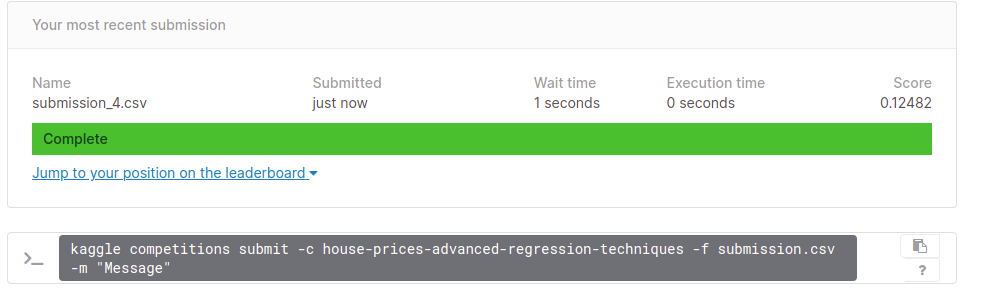